# Plotting sequence logos

The code in this tutorial is released under the [MIT License](https://opensource.org/licenses/MIT). All the content in this notebook is under a [CC-by 4.0 License](https://creativecommons.org/licenses/by/4.0/). 

In [1]:
import regseq.viz
import pandas as pd

import regseq.information
import numpy as np


import regseq.find_region as find_region

import matplotlib.pyplot as plt
%matplotlib inline

# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

For a detailed explanation of the steps leading to this notebook, as well as the experimental context, refer to the [Reg-Seq wiki](https://github.com/RPGroup-PBoC/RegSeq/wiki).

Previously we analyzed the datasets that can be obtained in a Reg-Seq experiment and using statistical inference methods to inferer how mutations at each base in a promoter sequence change gene expression, and we computed information footprints which we used to identify binding sites for repressors and activators. In this step, we are going to automatically identify significant binding sites and use the `logomaker` package to plot sequence logos of the identified sites.

First, let's look at the information footprint we created previously.

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/mpathic_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

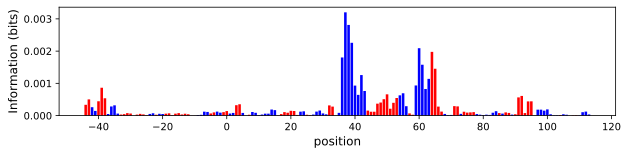

In [2]:
regseq.viz.footprint_from_emat("../data/results/MCMC/bdcRAnaerodataset_alldone_with_largeMCMC194", output_file=None, old_format=True, gene="bdcR")

We can use the information footprint to automatically find the regions that contain interesting regulatory features for plotting.

Previously we analyzed the data that is obtained in a Reg-Seq experiment, and performed statistical inference to infer how mutations in each base change the expression the gene. To identify where repressor or activator binding sites are, we have to look for regions in the sequence where mutations in adjacent bases have a significant change in expression. 

We first need to find the proper scaling factor for conversion to information logo. Empirically, it is known
that binding sites have approximately 1 bit of information per base pair.

In [3]:
regions = find_region.find_region("../data/results/MCMC/bdcRAnaerodataset_alldone_with_largeMCMC194", 
    old_format=True,
    gene="bdcR",growth='Anaero')

In [4]:
regions

,gene,feat_num,start,end,type
0,bdcR,0,0,9,act
1,bdcR,1,84,116,act
2,bdcR,0,76,110,rep


This is a repressor region overlapping the activator like RNAP region. We will plot the RNAP region as a sequence logo.

In [5]:
target_start = regions.loc[1,'start']
target_end = regions.loc[1,'end']

In [6]:
# Load in a binding site matrix.
file = "../data/inference_results/bdcRAnaero_LS_mut.csv"

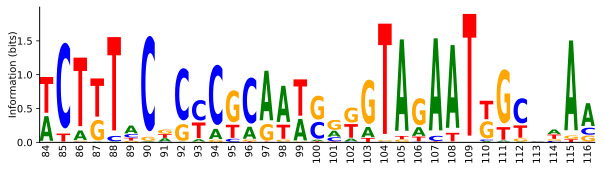

In [7]:
regseq.viz.logo(file, limit=(target_start,target_end))

We first need to find the proper scaling factor for conversion to information logo. Empirically, it is known
that binding sites have approximately 1 bit of information per base pair.

Finally, here are the versions of packages used in this notebook. To display the versions, we are using the Jupyter Lab extension `watermark`, which can be found [here](https://github.com/rasbt/watermark).

## Computing environment

In [8]:
%load_ext watermark
%watermark -v -p jupyterlab,numpy,pandas,logomaker,matplotlib

CPython 3.6.9
IPython 7.13.0

jupyterlab not installed
numpy 1.18.1
pandas 1.0.3
logomaker 0.8
matplotlib 3.1.3
